# Mestrado Prossional de Economia INSPER - Turma MPE16
# Trabalho de conclusão do curso de Finanças Quantitativas (2020.1)


#### Autores: Ciro Aloísio de Paula Duarte, João Italo Zecchin Reis, Robert Aldo Andreotti Filho 


#### O objetivo deste trabalho é criar uma estratégia de pair trading entre moedas de um mesmo bloco econômico, de modo que faça sentido a compração entre elas. Nossa proposta é usar os sinais de momentum, value e carry como critério de decisão para os negócios.

#### O relatório do trabalho está separado em três arquivos de Jupyter Notebook, onde esta é a primeira:
    Parte 1: Desenvolvimento dos trackers e dos sinais de momentum, value e carry das moedas analisadas contra o dólar.
    Parte 2: Criação da estratégia de trading.
    Parte 3: Realização do backtest.

Como fonte de dados usamos sempre dados extraídos da Bloomberg.

##  
## Parte 1

In [52]:
#import das bibliotecas
import os
import datetime
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
import statsmodels.api as sm
from scipy.stats import norm
%matplotlib inline


In [53]:
from bloomberg import BBG
bbg = BBG()

    Período analisado:

In [54]:
start_date ='2009-01-01'
end_date ='2019-12-31'

Este notebook foi desenvolvido para aceitar qualquer uma das moedas abaixo:

    AUD: Australian dollar
    BRL: Brazilian real
    CAD: Cannadian dollar
    CHF: Swiss franc
    CLP: Chilean peso 
    CZK: Czech koruna
    EUR: Euro
    GBP: British pound
    HUF: Hungarian forint
    JPY: Japanese yen
    KRW: South Korean won
    MXN: Mexican peso
    NOK: Norwegian krone
    NZD: New Zealand dollar
    PHP: Philippine peso
    PLN: Złoty
    SEK: Swedish krona
    SGD: Singapore dollar
    TRY: Turkish lira
    TWD: Taiwan dollar
    USD: American dollar
    ZAR: South African rand

In [55]:
#Dicionário usado para relacionar os símbolos das moedas com os códigos de suas taxas de juros na bloomberg
deposit_rates_dict = {'EUR': 'EUDRC', 'JPY': 'JYDRC', 'GBP': 'BPDRC', 'CHF': 'SFDRC', 'CAD': 'CDDRC', 'AUD': 'ADDRC', 
                      'NZD': 'NDDRC', 'NOK': 'NKDRC', 'SEK': 'SKDRC', 'DKK': 'DKDRC', 'CZK': 'CKDRC', 'HUF': 'HFDRC',
                      'ISK': 'IKDRC', 'PLN': 'PZDRC', 'SKK': 'VKDRC', 'TRY': 'TYDRC', 'ZAR': 'SADRC', 'HKD': 'HDDRC',
                      'INR': 'IRDRC', 'IDR': 'IHDRC', 'PHP': 'PPDRC', 'SGD': 'SDDRC', 'KRW': 'KWDRC', 'CNY': 'CCNI3M',
                      'MYR': 'MRDRC', 'TWD': 'NTDRC', 'THB': 'TBDRC', 'ARS': 'APDRC', 'BRL': 'BCDRC', 'CLP': 'CHDRC',
                      'COP': 'CLDRC', 'MXN': 'MPDRC', 'PEN': 'PSDRC', 'USD': 'USDRC'}

###   
#### Definição das moedas usadas na estratégia

Para executar nossa estratégia de trading decidimos separar as moedas em três grupos, cada qual com uma característica econômica. Fizemos o pair trading entre todas as moedas de uma mesma cesta.

Importante destacar que neste Jupyter Notebook todos os sinais e os trackers foram gerados considerando short USD e long moedas abaixo.

Separamos três blocos:

    - Moedas de países da Europa (EUR, GBP e SEK); 
    - Moedas de países relevantes em commodities (AUD, CAD, NOK e ZND);
    - Moedas de países emergentes e Latam (BRL e MXN);
    - (OPICIONAL) Moedas de países do sudeste asiático (PHP, SGD e TWD)

In [69]:
#inicialização das listas dos blocos para evitar que em novas execuções do código possa ter lixo na memória
europe = []
cmdty = []
latam = []
#seAsia = []

#definição dos blocos de moedas em listas
europe = ['EUR', 'GBP', 'SEK']
cmdty = ['AUD', 'CAD', 'NOK', 'NZD']
latam = ['BRL', 'MXN']
#seAsia = ['PHP', 'SGD' 'TWD']

#união das moedas em uma lista única
basket = europe + cmdty + latam #+ seAsia

In [70]:
#definição do dataframe pair_ccy que será usado ao londo do código
basket_df = pd.DataFrame(basket, columns = ['cross currency'])
pair_ccy = pd.DataFrame(index=basket_df.index, columns = ['cross currency', 'country id', 'deposit rates bbg', 'quote bbg']) 
for i,pair in basket_df.iterrows():
    pair_ccy.iloc[i]  = 0
    pair_ccy['cross currency'].iloc[i] = pair['cross currency'] + 'USD Curncy'
    pair_ccy['country id'].iloc[i] = basket[i]
    pair_ccy['deposit rates bbg'].iloc[i] = deposit_rates_dict[pair_ccy['country id'].iloc[i]] + ' BDSR Curncy'
    inverse_quote = bbg.fetch_contract_parameter(securities=pair_ccy['country id'].iloc[i] + ' Curncy', field='INVERSE_QUOTED')
    pair_ccy['quote bbg'].iloc[i] = pair_ccy['country id'].iloc[i]  + 'USD Curncy' if inverse_quote.iloc[0,0]=='Y' else 'USD' + pair_ccy['country id'].iloc[i]  + ' Curncy'
     
tot_ccy = len(pair_ccy)
pair_ccy

,cross currency,country id,deposit rates bbg,quote bbg
0,EURUSD Curncy,EUR,EUDRC BDSR Curncy,EURUSD Curncy
1,GBPUSD Curncy,GBP,BPDRC BDSR Curncy,GBPUSD Curncy
2,SEKUSD Curncy,SEK,SKDRC BDSR Curncy,USDSEK Curncy
3,AUDUSD Curncy,AUD,ADDRC BDSR Curncy,AUDUSD Curncy
4,CADUSD Curncy,CAD,CDDRC BDSR Curncy,USDCAD Curncy
5,NOKUSD Curncy,NOK,NKDRC BDSR Curncy,USDNOK Curncy
6,NZDUSD Curncy,NZD,NDDRC BDSR Curncy,NZDUSD Curncy
7,BRLUSD Curncy,BRL,BCDRC BDSR Curncy,USDBRL Curncy
8,MXNUSD Curncy,MXN,MPDRC BDSR Curncy,USDMXN Curncy


## TRACKERS

 . . . . . .  
 
 .......... 
 
 ....

Extrações de bases de dados da bloomberg:

In [71]:
#cotações das moedas contra o dólar
ticker_ccys = pair_ccy['cross currency'].tolist()
quote_bbg = bbg.fetch_series(securities=ticker_ccys, fields='PX_LAST', startdate=start_date, enddate=end_date)
quote_bbg = quote_bbg.fillna(method='ffill').dropna()

#deposit rates 3M do dólar, considerado como funding no calculo de excess return
fund_rate_data = bbg.fetch_series(securities='USDRC BDSR Curncy', fields='PX_LAST', startdate=start_date,enddate=end_date)

#deposit rates 3M das moedas da estratégia
ticker_rates = pair_ccy['deposit rates bbg'].values.tolist()
ccy_rates = bbg.fetch_series(securities=ticker_rates, fields='PX_LAST', startdate=start_date, enddate=end_date)

#concatenacao da base dados em um único dataframe
bbg_raw_data_df = pd.concat([quote_bbg, ccy_rates, fund_rate_data],join='outer',axis=1,sort=True)
bbg_raw_data_df = bbg_raw_data_df.fillna(method='ffill').dropna() # drop missing data

No bloco de código abaixo calculamos, para cada um dos pares de moeda, calculamos o spot return, total return e excess return, embora que para o trackers final consiramos apenas o excess return.

In [72]:
#inicialização dos dataframes
aux_df =  pd.DataFrame(index=pair_ccy.index, columns = ['ccy'])
aux_df['ccy'] = pair_ccy['cross currency'].apply(lambda x : x[:6])
spot_index_df = pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
total_return_df =  pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
excess_return_df =  pd.DataFrame(index=bbg_raw_data_df.index, columns = aux_df['ccy'].values.tolist())
spot_index_df.iloc[0] = 100
total_return_df.iloc[0] = 100
excess_return_df.iloc[0] = 100

#loop para todas as moedas
for i, pair in pair_ccy.iterrows():
    
    pair_ticker = pair['cross currency']
    for d in range(1, bbg_raw_data_df.shape[0]): 

        #spot return       
        fx_spot_ret = bbg_raw_data_df[pair_ticker].iloc[d]/bbg_raw_data_df[pair_ticker].iloc[d-1]
        spot_index_df[pair_ticker[:6]].iloc[d] = (spot_index_df[pair_ticker[:6]].iloc[d-1])*fx_spot_ret
        
        #interest return dos países diário
        interest_return = (bbg_raw_data_df.iloc[d-1,i + tot_ccy]/100) / 252 + 1                                                       

        #total return
        total_return = fx_spot_ret*interest_return
        total_return_df[pair_ticker[:6]].iloc[d] = (total_return_df[pair_ticker[:6]].iloc[d-1])*total_return        
        
        #calculo do funding
        funding_cost = (bbg_raw_data_df.iloc[d-1, 2*tot_ccy]/100) / 252 + 1
        
        #excess return
        excess_return = fx_spot_ret*interest_return/funding_cost
        excess_return_df[pair_ticker[:6]].iloc[d] = excess_return_df[pair_ticker[:6]].iloc[d-1]*excess_return

spot_index_df = spot_index_df.fillna(method='ffill').dropna()  
total_return_df = total_return_df.fillna(method='ffill').dropna()  
excess_return_df = excess_return_df.fillna(method='ffill').dropna()                                                                            

###   
Visualização gráfica dos trackers ao longo do tempo

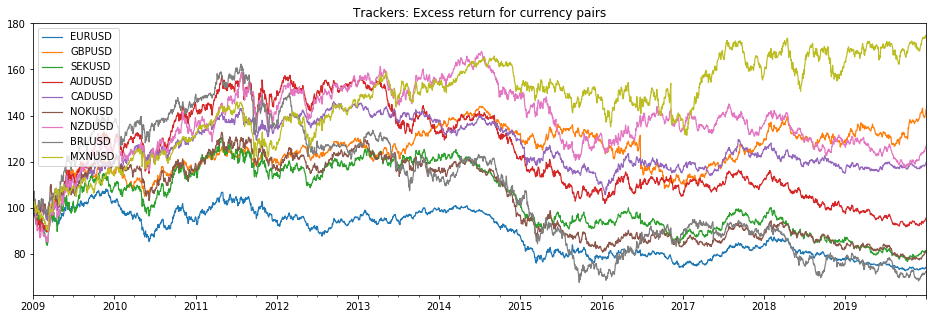

In [73]:
excess_return_df.plot(title='Trackers: Excess return for currency pairs',figsize=(16,5), linewidth=1.2)
plt.show()

##   
## MOMENTUM

 . . . . . .  
 
 .......... 
 
 ....

In [74]:
def get_lagged_vol(ts, h=21, vol_type='ewma', min_vol_window=756, halflife=60):
    lagged_data = ts.astype(float).shift(1)  # note the day lag!!
    lagged_data.index = pd.DatetimeIndex(pd.to_datetime(lagged_data.index))
    if vol_type == 'ewma': # From Moskowitz, Ooi, and Pedersen (2012) and roughly similar to a GARCH(1, 1) model        
        vols = np.sqrt(((np.log(lagged_data).diff(1)**2).ewm(halflife=halflife).mean())*252)
    else:
        if vol_type != 'rolling':
            print('vol_type not recognized, assuming rolling window of %s bdays over %s bday returns' % (min_vol_window,h))
        vols = np.log(lagged_data).diff(h).rolling(window=min_vol_window).std()*np.sqrt(252/h)
    return vols

In [75]:
def momentum_type(ts, h=252, signal_type='classic', vol_adjust=True):
    
    df = ts.astype(float).shift(1) 
    df.index = pd.to_datetime(df.index)

    if signal_type != 'classic':
        print('Momentum signal type was not recognized! assuming default')     
    else:
        df_mom = df.pct_change(h)

        if vol_adjust: 
            if isinstance(vol_adjust,bool):
                vols = get_lagged_vol(ts)                            
            else:
                vols = get_lagged_vol(ts,vol_type=vol_adjust)                                    
            return df_mom/vols
        else:                
            return df_mom

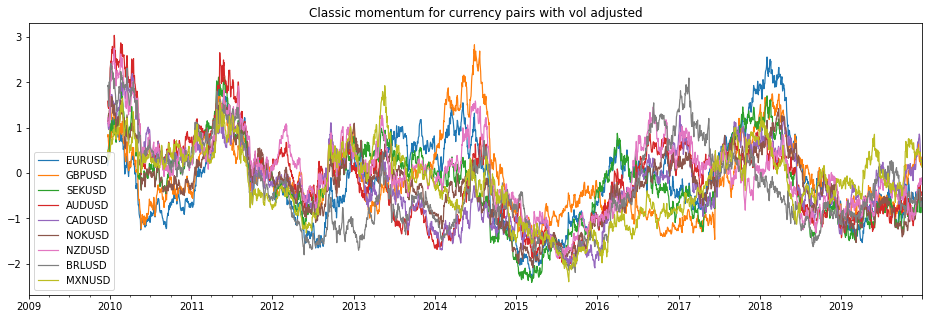

In [76]:
#As default signal_type='classic'and h = 252
momentum = pd.DataFrame()
for i, pair in pair_ccy.iterrows():
    momentum[pair['cross currency'][:6]] = momentum_type(quote_bbg[pair['cross currency']])
momentum.plot(title='Classic momentum for currency pairs with vol adjusted',figsize=(16,5), linewidth=1.2)
plt.show()

## VALUE

#### RER

$$
RER_{ccy1ccy2} = Spot_{ccy1ccy2} \times \frac{P_{ccy1}}{P_{ccy2}}
$$

#### PPP value


$$
Value_{ccy1ccy2} = \ln(RER_{ccy1ccy2})
$$


In [77]:
country_dic = {'AUD': 'AS', 'BRL': 'BZ', 'CAD': 'CA', 'CHF': 'SZ', 'CLP': 'CL', 'CZK': 'CZ', 'EUR': 'EUAR',
               'GBP': 'UK', 'HUF': 'HU', 'JPY': 'JN', 'KRW': 'KR', 'MXN': 'MX', 'NOK': 'NO', 'NZD': 'NZ',
               'PHP': 'PH', 'PLN': 'PL', 'SEK': 'SW', 'SGD': 'SG', 'TRY': 'TR', 'TWD': 'TW', 'USD': 'US',
               'ZAR': 'ZA'}

In [78]:
#Define value signals as lists
value =  pd.DataFrame()
zero_mean = pd.DataFrame()
zscore = pd.DataFrame()
ccy2 = 'USD'

#For each currency pair we find out the three types of value
for i, pair in pair_ccy.iterrows():
    ccy1 = basket[i]
    PPP_bbg = bbg.fetch_series(securities=[ccy1 + ' Curncy',ccy2 + ' Curncy',
                                            'PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index',
                                            'PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index'],
                                             fields='PX_LAST', startdate=start_date, enddate=end_date)
    
    PPP_bbg = PPP_bbg.fillna(method='ffill')
    RER = quote_bbg[pair['cross currency']] * PPP_bbg['PPP ' + country_dic[ccy1.replace(' Curncy','') ] + ' Index']/PPP_bbg['PPP ' + country_dic[ccy2.replace(' Curncy','') ] + ' Index']
    
    value[pair_ccy.iloc[i,0][:6]] = np.log(RER).fillna(method='ffill')
    zero_mean[pair_ccy.iloc[i,0][:6]]  = value[pair_ccy.iloc[i,0][:6]]  - value[pair_ccy.iloc[i,0][:6]].rolling(window=252).mean()
    zscore[pair_ccy.iloc[i,0][:6]] = (value[pair_ccy.iloc[i,0][:6]] - value[pair_ccy.iloc[i,0][:6]].rolling(window=252).mean())/value[pair_ccy.iloc[i,0][:6]].rolling(window=252).std()


## CARRY

#### Deposit rates

$$
Carry_{USDBRL}^{3M} = \frac{1+r_{USD}}{1+r_{BRL}}-1
$$

where $r_{USD}$ is the 3M USD deposit rate and $r_{BRL}$ is the 3M BRL interest rate.


#### Forwards

Recall that by a no-arbitrage argument a currency 3M forward contract should be prices by:

$$
F_{USDBRL}^{3M} = S_{USDBRL} \times \Big(\frac{1+r_{BRL}}{1+r_{USD}}\Big)^{3/12}
$$

where $S_{USDBRL}$ is the spot USDBRL exchange rate. So, an alternative way of defining the 3M annualized carry in USDBRL is:


$$
Carry_{USDBRL}^{3M} = \Big(\frac{S_{USDBRL}}{F_{USDBRL}^{3M}}\Big)^{12/3}-1
$$

#### Volatility adjusted carry

$$
\sigma_{USDBRL}^{-1} \times Carry_{USDBRL}^{3M}
$$

In [79]:
carry =  pd.DataFrame()
fwd_carry = pd.DataFrame()
vol_adj_carry = pd.DataFrame()


for i in range(tot_ccy):
    
    tickers_carry = [deposit_rates_dict[pair_ccy['country id'].iloc[i]] + ' BDSR Curncy', 
                    'USDRC BDSR Curncy', 
                     pair_ccy['cross currency'].iloc[i], 
                     pair_ccy['quote bbg'].iloc[i][:6] + 'V3M BGN Curncy']
    
    rates_bbg = bbg.fetch_series(securities=tickers_carry,fields='PX_LAST', startdate=start_date, enddate=end_date)
    rates_bbg = rates_bbg.fillna(method='ffill')
    rates_bbg['carry'] = (1+rates_bbg.iloc[:,1]/100)/(1+rates_bbg.iloc[:,0]/100)-1
    rates_bbg['fwd'] = rates_bbg.iloc[:,2]*((1+rates_bbg.iloc[:,0]/100)/(1+rates_bbg.iloc[:,1]/100))**(3/12)
    rates_bbg['fwd_carry'] = (rates_bbg.iloc[:,2]/rates_bbg['fwd'])**(12/3) -1
    rates_bbg['vol_adj_carry'] = rates_bbg['fwd_carry']/(rates_bbg.iloc[:,3]/100)

    carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['carry']
    fwd_carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['fwd_carry']
    vol_adj_carry[pair_ccy.iloc[i,0][:6]] = rates_bbg['vol_adj_carry']
    
    

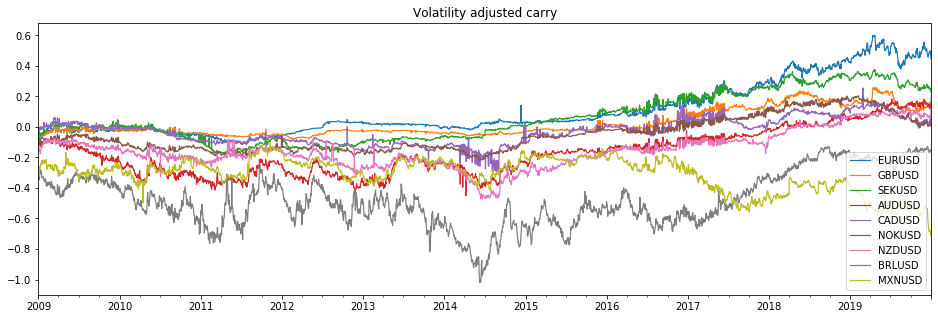

In [80]:
vol_adj_carry.plot(title='Volatility adjusted carry',figsize=(16,5), linewidth=1.2)
plt.show()

### Exportando sinais para excel

In [81]:
excess_return_df.to_excel("trackers.xlsx")
momentum.to_excel("momentum.xlsx")
zero_mean.to_excel("value.xlsx")
fwd_carry.to_excel("carry.xlsx")